In [1]:
%load_ext autoreload
import os
import sys

In [2]:
os.environ['TRANSFORMERS_CACHE'] = '/mnt/swordfish-pool2/milad/hf-cache-new'
os.environ['HF_DATASETS_CACHE'] = '/mnt/swordfish-pool2/milad/hf-cache-new'
os.environ["OPENAI_API_KEY"]= 'xxx'
os.environ['CUDA_VISIBLE_DEVICES'] = '4'
os.environ['CUDA_LAUNCH_BLOCKING'] = '0'
sys.path.append('./src-py')

In [3]:
import json
import os
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
import re
from collections import Counter

pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)


%autoreload
import utils
import prompts
import random
import datadreamer_generation

from tabulate import tabulate
import tiktoken
from llm_based_evaluation import *

/mnt/swordfish-pool2/milad/conda-envs/datadreamer/lib/python3.12/site-packages/transformers/utils/hub.py:128: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [4]:
from transformers import AutoTokenizer, pipeline

In [5]:
import json
keys = json.load(open('./keys.json'))
for key, val in keys.items():
    os.environ[key] = val

In [6]:
from huggingface_hub import login

login(os.environ['hf_token'])

In [7]:
output_dir = '/mnt/swordfish-pool2/milad/communicating-science-to-the-public/'
models_folder = "/mnt/swordfish-pool2/milad/communicating-science-to-the-public/models/"

In [8]:
gpt_tokenizer = tiktoken.encoding_for_model("gpt-3.5-turbo")
llama_tokenizer = AutoTokenizer.from_pretrained("meta-llama/Meta-Llama-3-8B")

- Now we will use the following models to generate conversations on a sample from the test set using only the generic prompt
    - LLAMA-3 baseline
    - Qwen baseline
    - LLAMA-3 fine-tuned on DeepSeek generated conversations
    - Qwen  fine-tuned on DeepSeek generated conversations

### Prepare a sample test dataset:

In [29]:
# Generate test sample

# test_ds = datasets.load_from_disk('/mnt/swordfish-pool2/milad/communicating-science-to-the-public/deepseek-final-conv-ds-preprocessed-test_journalist_ds')
# test_df = pd.DataFrame(test_ds)
# test_df = test_df.drop_duplicates('paper_id')
# test_ds = datasets.Dataset.from_pandas(test_df)
# sample_dataset = test_ds.select(range(500))
# sample_dataset.save_to_disk('/mnt/swordfish-pool2/milad/communicating-science-to-the-public/processed_test_ds_sample')

In [9]:
# Forgot to add the pr-article to the dataset --> so adding it now
deepseek_conv_dataset = datasets.load_from_disk('/mnt/swordfish-pool2/milad/communicating-science-to-the-public/deepseek-final-conv-ds-cleaned/')
paper_id_to_article = {x['id']: x['pr-article'] for x in deepseek_conv_dataset}
paper_id_to_topic = {x['id']: x['Topic'] for x in deepseek_conv_dataset}

In [10]:
# Load the created test sample

sample_dataset = datasets.load_from_disk('/mnt/swordfish-pool2/milad/communicating-science-to-the-public/processed_test_ds_sample')
sample_dataset = sample_dataset.map(lambda row: {'pr-article': paper_id_to_article[row['paper_id']]})
sample_dataset = sample_dataset.map(lambda row: {'topic': paper_id_to_topic[row['paper_id']]})

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [11]:
sample_dataset

Dataset({
    features: ['paper_id', 'paper_title', 'paper_text', 'prompt', 'completion', '__index_level_0__', 'pr-article', 'topic'],
    num_rows: 500
})

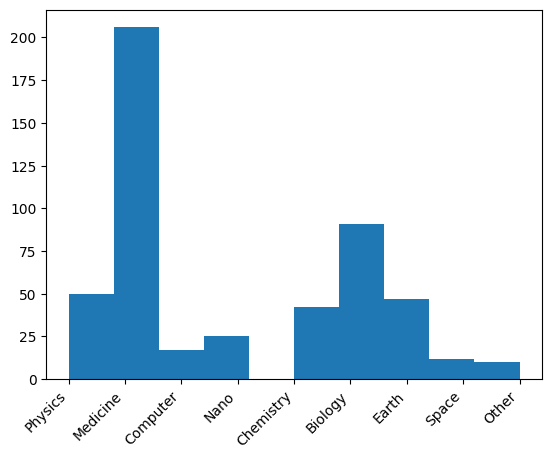

In [12]:
plt.hist(sample_dataset['topic'])
plt.xticks(rotation=45, ha='right')
plt.show()

### Generate conversations:

#### Generate full blown conversations:

In [13]:
all_prompts = utils.get_prompt_compositions()
used_prompt = all_prompts[4]
used_prompt['inputs']['Scientific paper'] = 'paper_text'

In [14]:
print(used_prompt['instruction'])

Please simulate a conversation between a researcher and a journalist regarding the researcher's scientific paper. The goal of the conversation is to gain a deeper understanding of the researcher's scientific paper and communicate its impact to the public through a journalistic report.

    Guidelines for Researcher's answers:
        
        1. The researcher are excellent at communicating your research in a simple and everyday life language
        2. The researcher knows how to communicate the socieal impact of your research.
        3. The researcher knows how to put your research in the proper scientific context
    
    Guidelines for the Journalist's questions:
        
        1. The journalist questions encouraging the researcher to place their paper in a proper societal and scientific context to the greatest possible degree.
        2. The journalist focus on topics in the paper that are novelty and have unexpected results.
        3. The journalist follow up on the researche

In [15]:
# output_dir = '/mnt/swordfish-pool2/milad/communicating-science-to-the-public/gpt3-test-conv-ds/'
# resulted_ds = datadreamer_generation.generate_conversation(output_dir, 'gpt-3', sample_dataset, used_prompt, gpt_tokenizer, max_input_tokens=1200)
# resulted_ds.save_to_disk(output_dir)

In [ ]:
output_dir = '/mnt/swordfish-pool2/milad/communicating-science-to-the-public/llama3-full-conv-test-conv-ds/'
resulted_ds = datadreamer_generation.generate_conversation(output_dir, 'llama3', sample_dataset, used_prompt, llama_tokenizer, max_input_tokens=1200, max_new_tokens=1000)
resulted_ds.save_to_disk(output_dir)

[ 🤖 DataDreamer 💤 ] Initialized. 🚀 Dreaming to folder: /mnt/swordfish-pool2/milad/communicating-science-to-the-public/llama3-full-conv-test-conv-ds/composite-experienced-researcher-generic-guidelines
[ 🤖 DataDreamer 💤 ] Step 'documents' is running. ⏳
[ 🤖 DataDreamer 💤 ] Step 'documents' finished and is saved to disk. 🎉
[ 🤖 DataDreamer 💤 ] Step 'documents (map)' is running. ⏳
[ 🤖 DataDreamer 💤 ] Step 'documents (map)' will run lazily. 🥱
/local/nlp/milad/code/llms-as-science-communicators/src-py/datadreamer_generation.py:139: UserWarning: You did not specify `total_num_rows`, so we cannot automatically update the progress % for this step. Either specify map(..., total_num_rows=#) or, to disable this warning, specify map(.., auto_progress = False)
  datasource = datasource.map(lambda row: {'inputs_truncated': truncate_text(encoding, row['inputs'], max_input_tokens)})
[ 🤖 DataDreamer 💤 ] Step 'documents (map) (map)' is running. ⏳
[ 🤖 DataDreamer 💤 ] Step 'documents (map) (map)' will run la

#### Generate conversations, turn by turn:

**Using the ft-LLAMAs**

In [12]:
output_path = '/mnt/swordfish-pool2/milad/communicating-science-to-the-public/ft-llama3-test-conv-ds/'

In [ ]:
journalist_model, tokenizer = utils.load_model_with_adapter("meta-llama/Meta-Llama-3-8B-Instruct",
                                                            "/mnt/swordfish-pool2/milad/communicating-science-to-the-public/models/llama3-trained-journalist-on-deepseek/", 
                                                            device_map="cuda:1")
journalist_pipeline = pipeline("text-generation", model=journalist_model, tokenizer=tokenizer, batch_size=12)
researcher_model, tokenizer = utils.load_model_with_adapter("meta-llama/Meta-Llama-3-8B-Instruct", 
                                                           "/mnt/swordfish-pool2/milad/communicating-science-to-the-public/models/llama3-trained-researcher-on-deepseek/", 
                                                            device_map="cuda:3")
researcher_pipeline = pipeline("text-generation", model=researcher_model, tokenizer=tokenizer, batch_size=12)

resulted_ds = utils.construct_full_dialogue(sample_dataset, journalist_pipeline, researcher_pipeline, max_rounds=5, max_journalist_turn_tokens=200, max_researcher_turn_tokens=500)
resulted_ds.save_to_disk(output_path)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Device set to use cuda:1


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Device set to use cuda:3
 40%|█████████████████████████████▌                                            | 2/5 [9:43:25<14:31:09, 17423.15s/it]

**Using the ft-Qwen**

In [ ]:
output_path = '/mnt/swordfish-pool2/milad/communicating-science-to-the-public/ft-qwen-full-ds-training-test-conv-ds'

In [ ]:
journalist_model, tokenizer = utils.load_model_with_adapter("Qwen/Qwen2.5-7B-Instruct",
                                                            "/mnt/swordfish-pool2/milad/communicating-science-to-the-public/models/qwen-trained-journalist-on-deepseek/", 
                                                            device_map="cuda:6")
journalist_pipeline = pipeline("text-generation", model=journalist_model, tokenizer=tokenizer, batch_size=6)
researcher_model, tokenizer = utils.load_model_with_adapter("Qwen/Qwen2.5-7B-Instruct", 
                                                           "/mnt/swordfish-pool2/milad/communicating-science-to-the-public/models/qwen-trained-researcher-on-deepseek/", 
                                                            device_map="cuda:7")
researcher_pipeline = pipeline("text-generation", model=researcher_model, tokenizer=tokenizer, batch_size=6)

resulted_ds = utils.construct_full_dialogue(sample_dataset, journalist_pipeline, researcher_pipeline, max_rounds=5, max_journalist_turn_tokens=200, max_researcher_turn_tokens=500)
resulted_ds.save_to_disk(output_path)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|                                                                                          | 0/5 [00:00<?, ?it/s]

**Using the baseline Qwen**

In [ ]:
output_dir = '/mnt/swordfish-pool2/milad/communicating-science-to-the-public/baseline-qwen-test-conv-ds/'

researcher_prompt = """
You are a helpful and expert researcher answering questions about your scientific paper. 
1. You are excellent at communicating your research in a simple and everyday life language
2. You know how to communicate the socieal impact of your research.
3. You know how to put your research in the proper scientific context

Answer the question in maximum two to three paragraphs
"""
journalist_prompt = """
You are a helpful and knowledgeable journalist asking questions about a scientific paper. 
1. Your questions encouraging the researcher to place their paper in a proper societal and scientific context to the greatest possible degree.
2. Your questions focus on topics in the paper that are novelty and have unexpected results.
3. Your questions follow up on the researcher's answers trying to clarify unexplained technical terms in everyday language.

Ask a new question or a follow-up question on the conversation
"""

# researcher_prompt = """
# You are a helpful and expert researcher answering questions about your scientific paper. Answer the question in maximum one paragraph
# """
# journalist_prompt = """
# You are a helpful and knowledgeable journalist asking questions on a scientific paper. Please ask a new question or follow-up question on the following
# """

journalist_model, tokenizer = utils.load_model_with_adapter("Qwen/Qwen2.5-7B-Instruct", device_map="cuda:6")
journalist_pipeline = pipeline("text-generation", model=journalist_model, tokenizer=tokenizer, batch_size=8)
researcher_model, tokenizer = utils.load_model_with_adapter("Qwen/Qwen2.5-7B-Instruct", device_map="cuda:5")
researcher_pipeline = pipeline("text-generation", model=researcher_model, tokenizer=tokenizer, batch_size=8)

resulted_ds = utils.construct_full_dialogue(sample_dataset, journalist_pipeline, researcher_pipeline, max_rounds=5, 
                                                     max_journalist_turn_tokens=200, max_researcher_turn_tokens=500, researcher_prompt=researcher_prompt, journalist_prompt=journalist_prompt)
resulted_ds.save_to_disk(output_dir)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Device set to use cuda:6


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Device set to use cuda:5
 60%|█████████████████████████████████████████████▌                              | 3/5 [7:45:31<5:20:13, 9606.94s/it]

**Using the baseline LLAMA-3**

In [ ]:
output_dir = '/mnt/swordfish-pool2/milad/communicating-science-to-the-public/baseline-advanced-prompt-llama3-test-conv-ds/'

researcher_prompt = """
You are a helpful and expert researcher answering questions about your scientific paper. 
1. You are excellent at communicating your research in a simple and everyday life language
2. You know how to communicate the socieal impact of your research.
3. You know how to put your research in the proper scientific context

Answer the question in maximum two to three paragraphs
"""
journalist_prompt = """
You are a helpful and knowledgeable journalist asking questions about a scientific paper. 
1. Your questions encouraging the researcher to place their paper in a proper societal and scientific context to the greatest possible degree.
2. Your questions focus on topics in the paper that are novelty and have unexpected results.
3. Your questions follow up on the researcher's answers trying to clarify unexplained technical terms in everyday language.

Ask a new question or a follow-up question on the conversation
"""

journalist_model, tokenizer = utils.load_model_with_adapter("meta-llama/Meta-Llama-3-8B-Instruct", device_map="cuda:6")
journalist_pipeline = pipeline("text-generation", model=journalist_model, tokenizer=tokenizer, batch_size=8)
researcher_model, tokenizer = utils.load_model_with_adapter("meta-llama/Meta-Llama-3-8B-Instruct", device_map="cuda:5")
researcher_pipeline = pipeline("text-generation", model=researcher_model, tokenizer=tokenizer, batch_size=8)

resulted_ds = utils.construct_full_dialogue(sample_dataset, journalist_pipeline, researcher_pipeline, max_rounds=5, 
                                                     max_journalist_turn_tokens=200, max_researcher_turn_tokens=500, 
                                                     researcher_prompt=researcher_prompt, journalist_prompt=journalist_prompt)
resulted_ds.save_to_disk(output_dir)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Device set to use cuda:6


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Device set to use cuda:5
 60%|█████████████████████████████████████████████▌                              | 3/5 [7:35:45<5:05:23, 9161.70s/it]